# Recreate AdeMAMix Rosenbrock Plot from Paper
This notebook attempts to recreate Figure 2 from the [AdeMAMix paper](https://arxiv.org/pdf/2409.03137)

## Imports

In [1]:
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rc('figure', figsize=(20, 10))
plt.rc('font', size=14)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
from optax.schedules import linear_schedule
from optax._src import base

## Functions

In [3]:
def rosenbrock(x):
    return jnp.square(1 - x[0]) + 100. * jnp.square(x[1] - jnp.square(x[0]))

# Create a grid of x and y values
#X, Y = np.meshgrid(np.linspace(-1.3, 1.3, 31), np.linspace(-0.9, 1.7, 31))
x = jnp.linspace(-5, 10, 1000)
y = jnp.linspace(-5, 10, 1000)
X, Y = jnp.meshgrid(x, y)

# Compute the Rosenbrock function values for each point on the grid
Z = rosenbrock([X, Y])

In [21]:
num_iterations = 100000

## Generate Adam Trajectories (Baseline)

In [22]:
all_b1_params = []
for b1 in [0.9,0.99,0.999,0.9999]:
    solver = optax.adam(
        learning_rate=0.003,
        b1=b1,
        b2=0.9999,
    )
    params = jnp.array([-3.,5.])
    print("Objective function: ", rosenbrock(params))
    all_params=[params]
    opt_state = solver.init(params)
    for i in range(num_iterations):
        grad = jax.grad(rosenbrock)(params)
        updates, opt_state = solver.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        all_params.append(params)
        if i%10000 == 0:
            print(f"Objective function for b1={b1} at iteration {i} = {rosenbrock(params)}")
    all_b1_params.append(all_params)
all_b1_params_array = jnp.array(all_b1_params)

Objective function:  1616.0
Objective function for b1=0.9 at iteration 0 = 1599.2254638671875
Objective function for b1=0.9 at iteration 10000 = 10.89592456817627
Objective function for b1=0.9 at iteration 20000 = 9.620516777038574
Objective function for b1=0.9 at iteration 30000 = 7.285767555236816
Objective function for b1=0.9 at iteration 40000 = 3.306288242340088
Objective function for b1=0.9 at iteration 50000 = 0.26169437170028687
Objective function for b1=0.9 at iteration 60000 = 0.009876935742795467
Objective function for b1=0.9 at iteration 70000 = 9.95625596260652e-05
Objective function for b1=0.9 at iteration 80000 = 6.432726706862013e-08
Objective function for b1=0.9 at iteration 90000 = 5.157154703283595e-10
Objective function:  1616.0
Objective function for b1=0.99 at iteration 0 = 1599.2254638671875
Objective function for b1=0.99 at iteration 10000 = 10.799932479858398
Objective function for b1=0.99 at iteration 20000 = 9.439836502075195
Objective function for b1=0.99 at

## Generate AdeMAMix Trajectories

### Create `alpha` scheduler

In [23]:
alpha = 0.8
alpha = linear_schedule(0, alpha, num_iterations)

### Create `b3` scheduler

In [24]:
def b3_scheduler(beta_end: float, beta_start: float = 0, warmup: int = 0):
    def f(beta):
        return jnp.log(0.5) / jnp.log(beta) - 1

    def f_inv(t):
        return jnp.power(0.5, 1 / (t + 1))

    def schedule(step):
        is_warmup = jnp.array(step < warmup).astype(jnp.float32)
        alpha = step / float(warmup)
        return is_warmup * f_inv(
            (1.0 - alpha) * f(beta_start) + alpha * f(beta_end)
        ) + beta_end * (1.0 - is_warmup)

    return schedule

In [25]:
all_ademamix_params = []
for b3 in [0.999,0.9999]:
    b3 = b3_scheduler(b3, 0, num_iterations)
    solver = optax.contrib.ademamix(
        learning_rate=0.003,
        b1=.99,
        b2=0.999,
        b3=b3,
        alpha=alpha,
    )
    params = jnp.array([-3.,5.])
    print("Objective function: ", rosenbrock(params))
    all_params=[params]
    opt_state = solver.init(params)
    for i in range(num_iterations):
        grad = jax.grad(rosenbrock)(params)
        updates, opt_state = solver.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        all_params.append(params)
        if i%1000 == 0:
            print(f"Objective function for b3={b3(i)} at iteration {i} = {rosenbrock(params)}")
    all_ademamix_params.append(all_params)
all_ademamix_params_array = jnp.array(all_ademamix_params)

Objective function:  1616.0
Objective function for b3=0.0 at iteration 0 = 1599.227294921875
Objective function for b3=0.9047933220863342 at iteration 1000 = 11.408196449279785
Objective function for b3=0.9512062072753906 at iteration 2000 = 11.29694652557373
Objective function for b3=0.9672003984451294 at iteration 3000 = 11.221567153930664
Objective function for b3=0.9752980470657349 at iteration 4000 = 11.092667579650879
Objective function for b3=0.9801891446113586 at iteration 5000 = 10.87605094909668
Objective function for b3=0.98346346616745 at iteration 6000 = 10.514174461364746
Objective function for b3=0.9858089685440063 at iteration 7000 = 9.911301612854004
Objective function for b3=0.9875717759132385 at iteration 8000 = 8.91100025177002
Objective function for b3=0.9889450073242188 at iteration 9000 = 7.268399715423584
Objective function for b3=0.9900450110435486 at iteration 10000 = 4.631922721862793
Objective function for b3=0.9909458756446838 at iteration 11000 = 1.0591912

## Plot the Figure

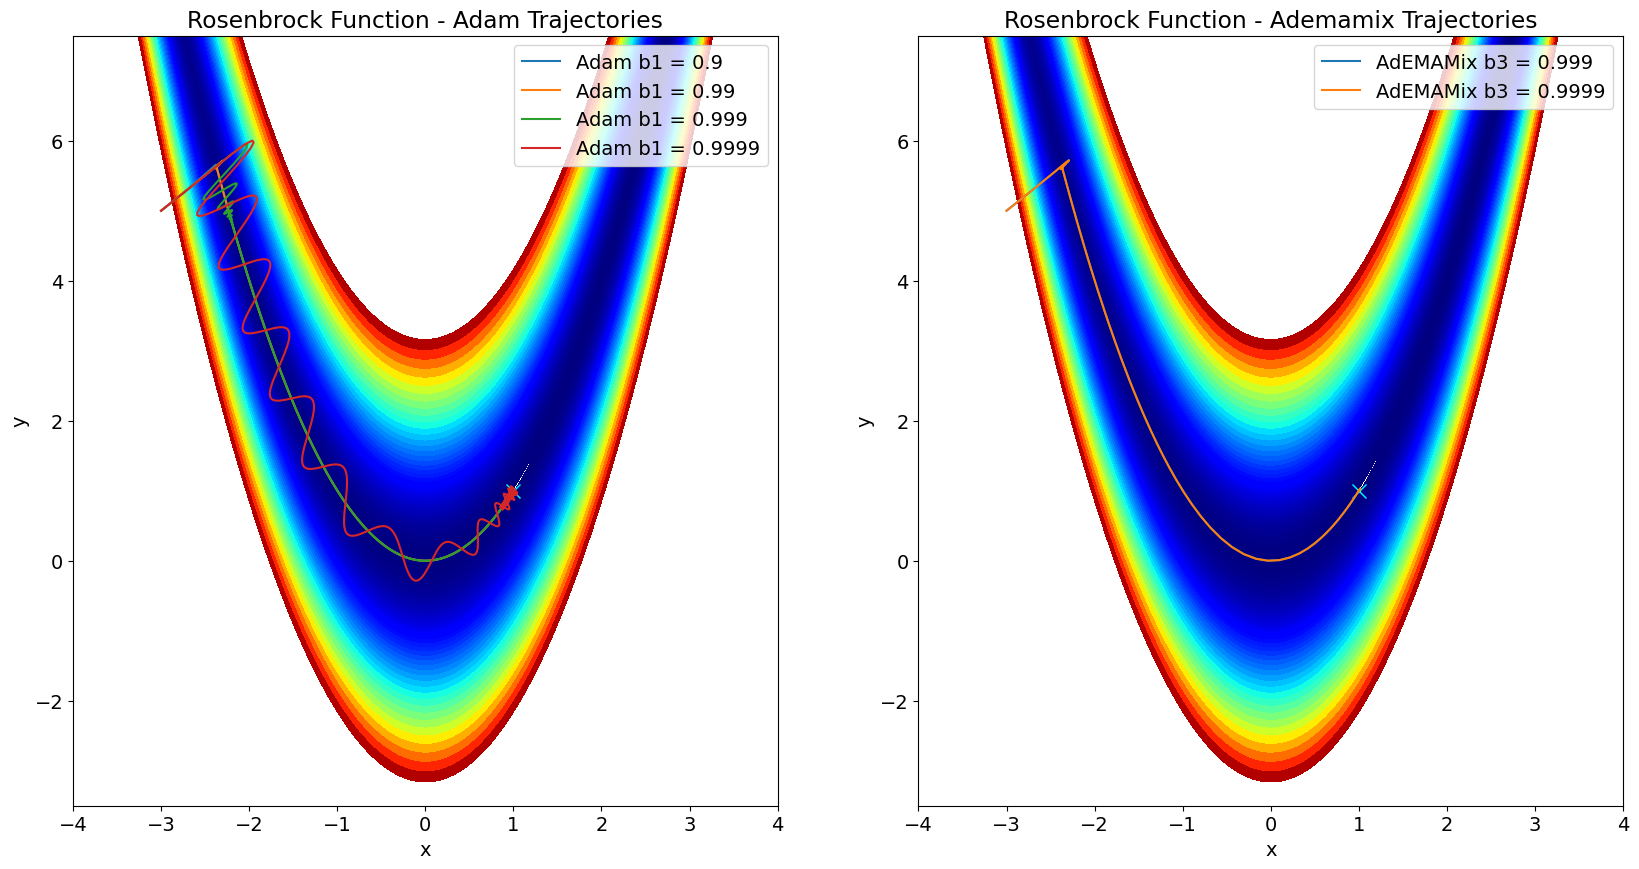

In [26]:
fig = plt.figure()
ax = fig.subplots(1,2)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Rosenbrock Function - Adam Trajectories')
# Show the plot
ax[0].plot([1], [1], 'x', mew=1, markersize=10, color='cyan')
ax[0].contourf(X, Y, Z, np.logspace(-1, 3, 100), cmap='jet')
for i, b1 in enumerate([0.9,0.99,0.999,0.9999]):
    ax[0].plot(all_b1_params_array[i,::100,0], all_b1_params_array[i,::100,1],label=f'Adam b1 = {b1}')
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-3.5,7.5)
ax[0].legend()

ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Rosenbrock Function - Ademamix Trajectories')
# Show the plot
ax[1].plot([1], [1], 'x', mew=1, markersize=10, color='cyan')
ax[1].contourf(X, Y, Z, np.logspace(-1, 3, 100), cmap='jet')
for i, b3 in enumerate([0.999,0.9999]):
    ax[1].plot(all_ademamix_params_array[i,::100,0], all_ademamix_params_array[i,::100,1],label=f'AdEMAMix b3 = {b3}')
ax[1].set_xlim(-4,4)
ax[1].set_ylim(-3.5,7.5)
ax[1].legend()

plt.show()

## Plot Figure 2a from Paper

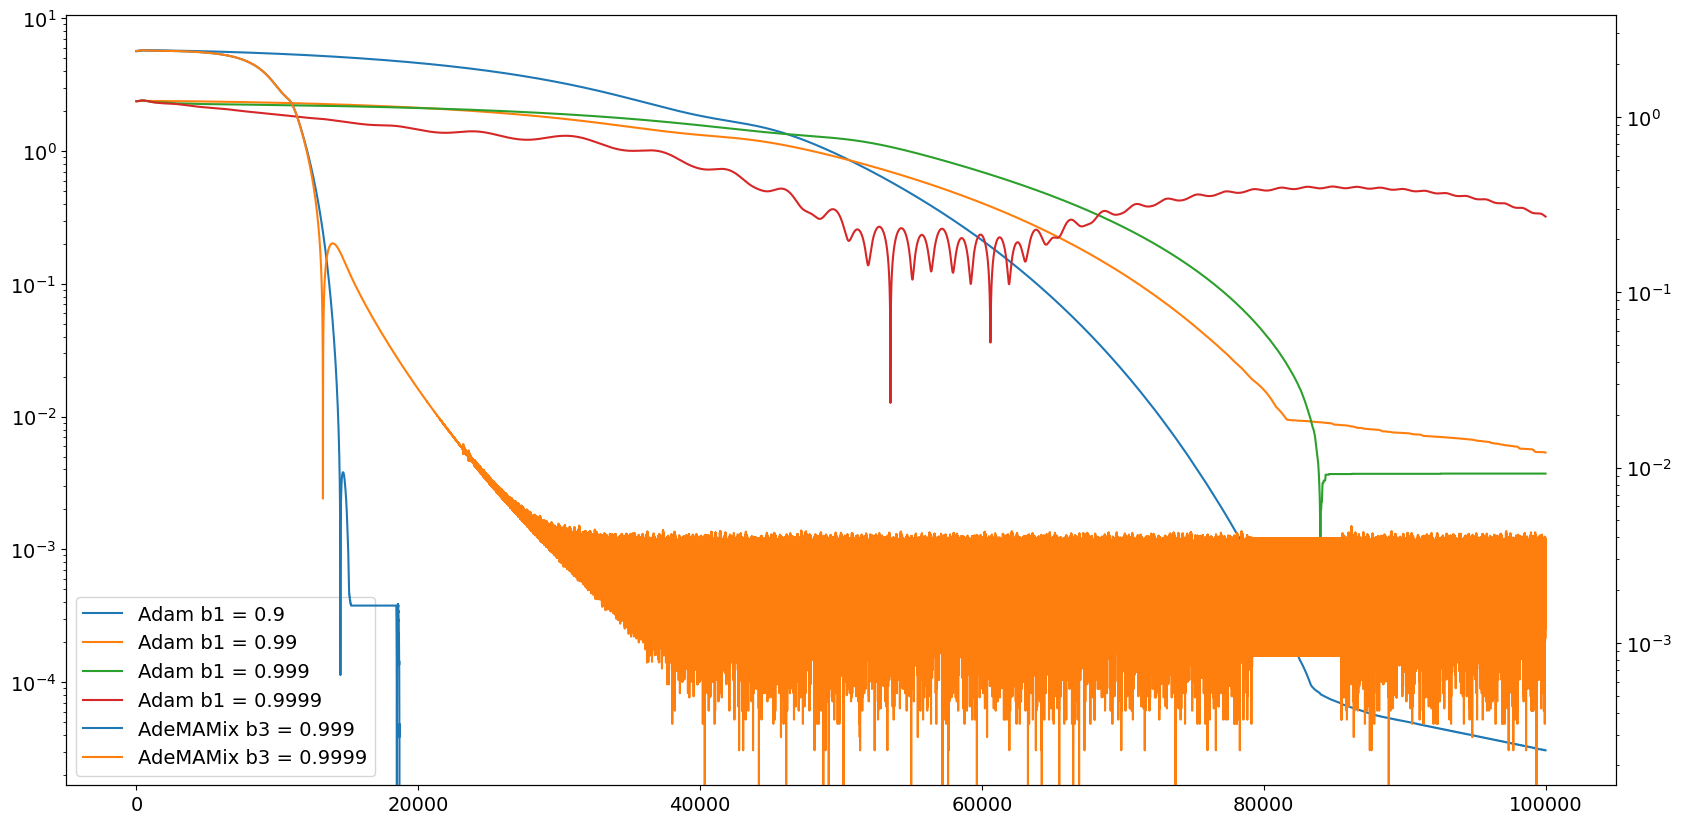

In [27]:
N = num_iterations+1
fig, ax = plt.subplots()
lns = ax.semilogy(jnp.arange(N), jnp.linalg.norm(all_b1_params_array[0,:,:]-jnp.ones(2,),axis=1),label=f'Adam b1 = 0.9')
for i,b1 in enumerate([0.99,0.999,0.9999]):
    lns += ax.semilogy(
        jnp.arange(N), 
        jnp.sqrt(jnp.linalg.norm(all_b1_params_array[i+1,:,:]-jnp.ones(2,),axis=1)),label=f'Adam b1 = {b1}'
    )
ax1 = ax.twinx()
for i,b3 in enumerate([0.999,0.9999]):
    lns += ax1.semilogy(
        jnp.arange(N), 
        jnp.sqrt(jnp.linalg.norm(all_ademamix_params_array[i,:,:]-jnp.ones(2,),axis=1)),label=f'AdeMAMix b3 = {b3}'
    )
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.show()

## Print out final values

In [28]:
print("Adam Values:")
[0.9,0.99,0.999,0.9999]
print(f"Final value with b1 = 0.9: ({float(all_b1_params_array[0,-1,0]),float(all_b1_params_array[0,-1,1])})")
print(f"Final value with b1 = 0.99: ({float(all_b1_params_array[1,-1,0]),float(all_b1_params_array[1,-1,1])})")
print(f"Final value with b1 = 0.999: ({float(all_b1_params_array[2,-1,0]),float(all_b1_params_array[2,-1,1])})")
print(f"Final value with b1 = 0.9999: ({float(all_b1_params_array[3,-1,0]),float(all_b1_params_array[3,-1,1])})")

print("AdeMAMix Values:")
print(f"Final value with b3 = 0.999: ({float(all_ademamix_params_array[0,-1,0]),float(all_ademamix_params_array[0,-1,1])})")
print(f"Final value with b3 = 0.9999: ({float(all_ademamix_params_array[1,-1,0]),float(all_ademamix_params_array[1,-1,1])})")

Adam Values:
Final value with b1 = 0.9: ((0.9999862909317017, 0.9999725818634033))
Final value with b1 = 0.99: ((0.9999871850013733, 0.9999743103981018))
Final value with b1 = 0.999: ((1.0000061988830566, 1.0000123977661133))
Final value with b1 = 0.9999: ((0.9527199268341064, 0.9080769419670105))
AdeMAMix Values:
Final value with b3 = 0.999: ((1.0, 1.0))
Final value with b3 = 0.9999: ((1.0000046491622925, 0.9999949932098389))
